In [1]:
import os
import pickle
import importlib
import numpy as np
from numpy.linalg import qr, solve, norm
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from rossler_map import RosslerMap, Model, Feedforward, my_custom_loss, train
from time_series import Rossler_model
from TP import lyapunov_exponent, newton

Rossler Map run :

In [26]:
### Build the data and the target trajectory
Niter = int(1e5)
delta_t = 1e-3 # or 1e-2
ROSSLER_MAP = RosslerMap(delta_t=delta_t)
INIT = np.array([-5.75, -1.6,  0.02])
traj, t = ROSSLER_MAP.full_traj(Niter, INIT)
    
X_train = torch.tensor(traj) #torch.tensor(np.concatenate([traj[:-2], traj[1:-1]], axis=1)) # torch.tensor(traj[:-1])
y_train = torch.tensor(ROSSLER_MAP.jacobian(traj)) #torch.tensor(np.concatenate([traj[1:-1], traj[2:]], axis=1)) # torch.tensor(traj[1:])
training_set = TensorDataset(X_train, y_train)


### Consider a model to solve our task
model = Feedforward(n_hidden_layers=3, n_neurons=10)
print(model)

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 128

criterion = my_custom_loss # nn.L1Loss() # TO ADAPT

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # TO ADAPT

error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=True)

### Test our model
# Select a new initialization
with torch.no_grad():
    trajectory_simul=[torch.tensor([-5.75, -1.6,  0.02])]

# Predict the next state and add it to the training
with torch.no_grad():
    for k in range(Niter-1):
        trajectory_simul.append(model(trajectory_simul[-1]))

(100000, 3)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

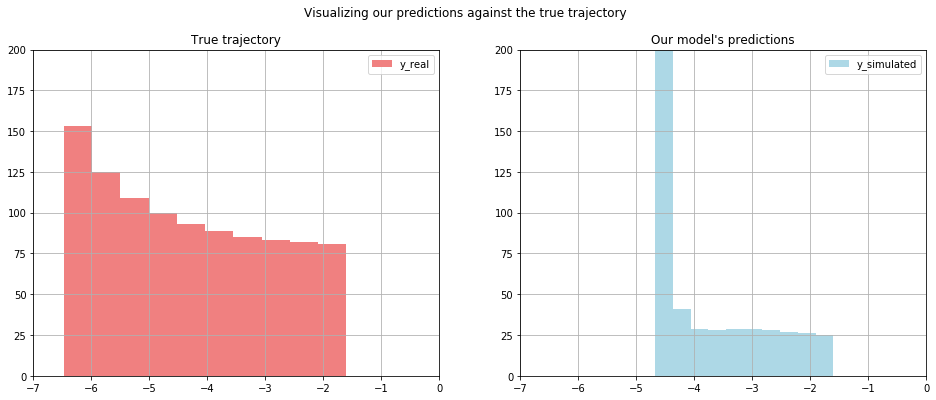

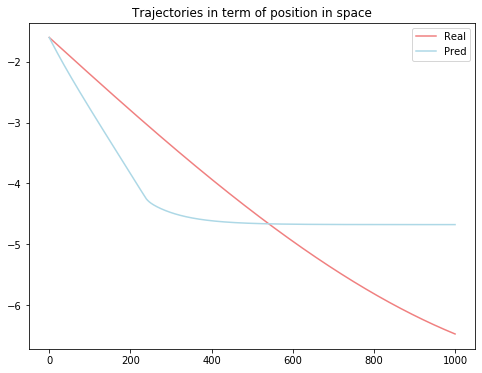

In [18]:
# Get the corresponding predicted trajectory over an axis
axis = 1
y_trajectory = []
for k in range(Niter):
    y_trajectory.append(trajectory_simul[k][axis].item())

# Get the real trajectory
y_real=[]
for k in range(Niter):
    y_real.append(traj[k][axis])

length = 1000
# Creates two subplots and unpacks the output array immediately
fig = plt.figure(figsize=(16,6))
fig.suptitle('Visualizing our predictions against the true trajectory')
plt.subplot(121)
plt.hist(y_real[:length], label="y_real", color="lightcoral")
plt.title('True trajectory')
plt.xlim(-7, 0)
plt.ylim(0, length//5)
plt.legend()
plt.grid()

plt.subplot(122)
plt.hist(y_trajectory[:length], label="y_simulated",color="lightblue")
plt.title("Our model's predictions")
plt.xlim(-7, 0)
plt.ylim(0, length//5)
plt.legend()
plt.grid()

fig = plt.figure(figsize=(8,6))
plt.plot(y_real[:length], color="lightcoral", label='Real')
plt.plot(y_trajectory[:length], color="lightblue", label='Pred')
plt.title('Trajectories in term of position in space')
plt.legend()

plt.show()

### Save our model
main_dir = '../models'
if not os.path.exists(main_dir):
    os.mkdir(main_dir)
model_path = os.path.join(main_dir,'model.pickle')
pickle.dump(model, open(model_path, 'wb'),protocol=4)

Time series run :

```python
out_dir = '../outputs'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
traj_path = os.path.join(out_dir,'y.tab')

delta_t = 1e-3

ROSSLER = Rossler_model(delta_t, model_path, traj_path)

y = ROSSLER.full_traj()

ROSSLER.save_traj(y)
```

TP main :

In [19]:
pred_traj = []
for coord in trajectory_simul:
    pred_traj.append(coord.numpy())
pred_traj = np.array(pred_traj)

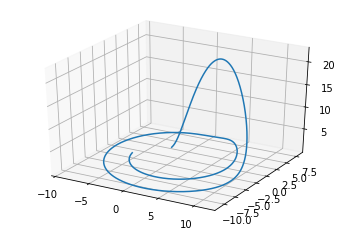

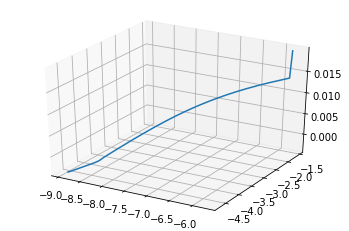

In [20]:
length = 10000
### Plot both trajectories and get the result
for trajectory in [traj, pred_traj]:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(trajectory[:length,0], trajectory[:length,1], trajectory[:length,2])
    plt.show()

equilibrium state : [ 0.0070262  -0.03513102  0.03513102] , error :  2.0811522028509542e-13
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
Lyapunov Exponents : [ 9.35819159e-02 -1.17761798e-03 -5.42547278e+00] with delta t = 0.001


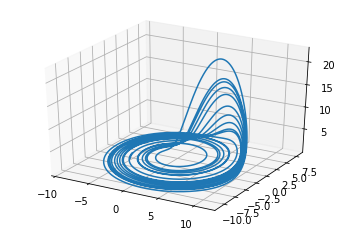

In [9]:
fix_point = newton(ROSSLER_MAP.v_eq, ROSSLER_MAP.jacobian, INIT)

error = norm(fix_point - ROSSLER_MAP.equilibrium())
print("equilibrium state :", fix_point, ", error : ", error)

lyap = lyapunov_exponent(traj, ROSSLER_MAP.jacobian, max_it=Niter, delta_t=delta_t)
print("Lyapunov Exponents :", lyap, "with delta t =", delta_t)